# Missing Value and Outlier Analysis

## Importing Data

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

# Display 100 columns max
pd.set_option('display.max_columns', 100)

# Display 20 characters max within a cell
# pd.set_option('max_colwidth',60)

In [2]:
df = pd.read_pickle("scout_for_missing_and_outliers.pkl")

In [3]:
df.shape

(15919, 129)

# Missing Value Analysis

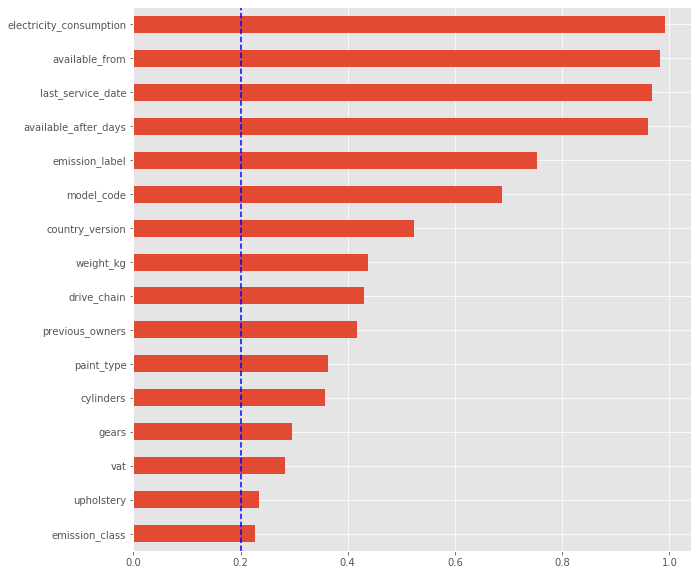

In [4]:
# Percentage of missing values withing columns (new dataset with missing values > 0)
ax = df.isnull().mean()[df.isnull().mean() > 0.2].sort_values().plot.barh(figsize=(10,10))
ax.axvline(x=0.2, color='b', linestyle='--')

In [5]:
# columns_to_keep = ['emission_class', 'consumption', 'nr.of seats']

In [6]:
# Create a new DataFrame with columns < 0.2 missing
df = df.loc[:, df.isnull().mean() < 0.2]
df.shape

(15919, 113)

In [7]:
# Select non-dummy columns
non_dummy = df.loc[:, ~df.columns.str.contains('ss_|cc_|^ext_|ent_', regex=True)]
non_dummy.shape

(15919, 19)

In [8]:
# Ratio and number of the missing values for non-dummy columns
pd.DataFrame({"Ratio" : non_dummy.isna().mean().sort_values(ascending=False), 
             "Number": non_dummy.isna().sum().sort_values(ascending=False)})

gearing_type          0.000000
price                 0.000000
inspection_new        0.000000
warranty              0.000000
make                  0.000000
model                 0.000000
type                  0.000126
fuel                  0.000377
body                  0.003769
hp                    0.005528
nr_of_doors           0.013317
displacement          0.031158
body_color            0.037502
nr_of_seats           0.061373
km                    0.064326
age                   0.100320
first_registration    0.100320
co2_emission          0.153025
consumption_comb      0.181104
dtype: float64

The most significant factors are (initial modeing results):
 - Model > no missing
 - Make > no missing
 - Type > almost no missing
 - Age > many missing *****
 - Gearing type (manuel, automatic, semi-automatic) > no missing
 - cc_, ss_, ent_, ext_  > many missing
 - Body > almost no missing
 - hp > almost no missing
 - Nr.of Doors > almost no missing
 - km > almost no missing
 
????Normalize ettigimiz icin yukaridaki degerleri, significance level (feature importance level) olarak da alabilir miyiz?

Ideas:
----
- `Make` and `model` have no missing values. This might be because of the web scraping algorithm, since we used make and model as parameters in the scraping process. (it might be worth trying not specifying `make` and `model` in the scraping process and see what we'll get)
- `Make` and `model` can be used to fill missing values for many columns. Using `.groupby()` is a good  option. One of the following strategies can be chosen.
    + Mean
    + Median
    + Mode (Most frequent)
- It is not possible to use `make` and `model` to fill every column. We'll investigate correlations to develop a better strategy to impute missing values for the following columns:
    + `Age`
    + `Km`

Text(0.5, 1, 'Correlation Heatmap of Non-Dummy Variables')

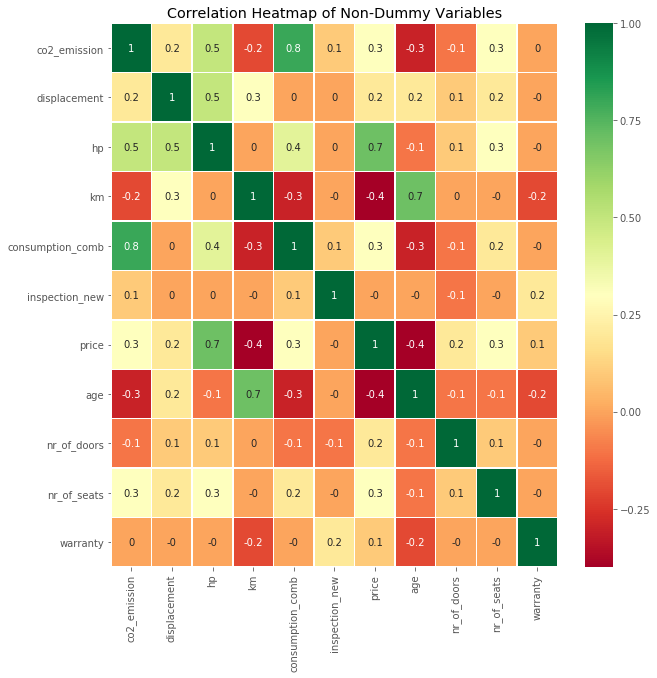

In [9]:
# Add figure size
plt.figure(figsize=(10,10))

# Plot heatmap of correlations
ax = sns.heatmap(non_dummy.corr().round(1), linewidths=.5, cmap="RdYlGn", annot=True)
ax.set_title('Correlation Heatmap of Non-Dummy Variables')

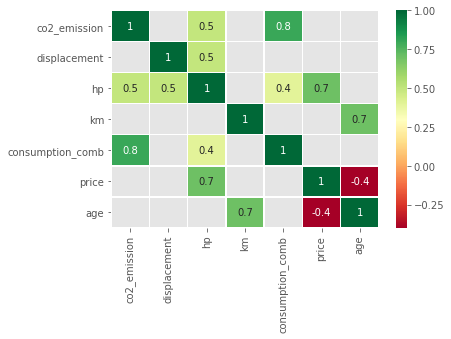

In [10]:
# Create a correlation DataFrame
corr = non_dummy.corr()

# Which columns are correlated
cols = ((corr.abs() > 0.4) & (corr.abs() < 1)).sum() > 0

# Plot the new correlation matrix
ax = sns.heatmap(corr.loc[cols,cols][corr.loc[cols,cols].abs() > 0.4].round(1), linewidths=.5, cmap="RdYlGn", annot=True)

Ideas: 
---
- We can use `km` to fill `age`, since there are more missings in the `age` column. We can also use `age` to fill `km` if the missings do not match.
- We can use `co2_emission` and `hp` to fill `consumption_comb`, and vice versa.
- We may drop `consumption_comb` since it is highly correlated and there are almost %20 missing. But first, we may use it to fill `co2_emission`.
- `hp` has correlation with many columns. 
- Regression to fill might be another option.

## Outlier Analysis

In [11]:
# Select numeric columns (without dummies)
df_numeric = non_dummy.select_dtypes('number')
df_numeric.describe()

,co2_emission,displacement,hp,km,consumption_comb,inspection_new,price,age,nr_of_doors,nr_of_seats,warranty
count,13483.000000,15423.000000,15831.000000,14895.000000,13036.000000,15919.000000,15919.000000,14322.000000,15707.000000,14942.000000,15919.000000
mean,117.953942,1423.540881,88.367696,34130.127828,4.784527,0.224260,18019.896727,1.542382,4.656077,4.949873,0.659526
std,20.245589,333.530658,26.835135,37352.977568,0.919294,0.417107,7386.169409,1.076917,0.645298,0.489872,0.473883
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,13.000000,0.000000,1.000000,2.000000,0.000000
25%,104.000000,1229.000000,66.000000,5153.000000,4.000000,0.000000,12850.000000,1.000000,4.000000,5.000000,0.000000
50%,116.000000,1461.000000,85.000000,22740.000000,4.700000,0.000000,16900.000000,1.000000,5.000000,5.000000,1.000000
75%,129.000000,1598.000000,101.000000,49371.500000,5.400000,0.000000,21900.000000,3.000000,5.000000,5.000000,1.000000
max,990.000000,16000.000000,294.000000,317000.000000,9.100000,1.000000,74600.000000,3.000000,7.000000,7.000000,1.000000


In [12]:
# Create a list of columns for outlier analysis
column_list = ["co2_emission", "displacement", "hp", "consumption_comb"]

# Print min and max values
pd.DataFrame({'min':df[column_list].min(), 'max':df[column_list].max()})

,min,max
co2_emission,0.0,990.0
displacement,1.0,16000.0
hp,1.0,294.0
consumption_comb,0.0,9.1


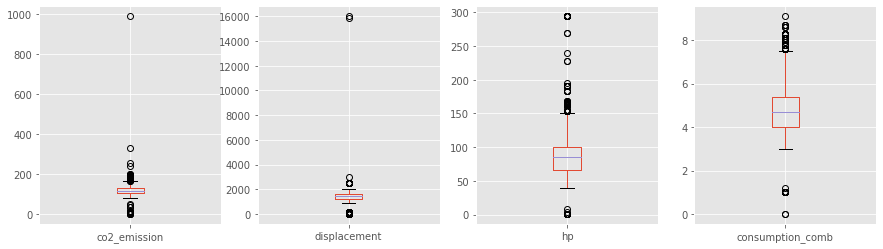

In [13]:
# Create subplots
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

# Plot subplots
i = 0
for column in column_list:
    # Plot boxplot[i]
    df[column].plot.box(ax = ax[i])
    
    # Next subplot
    i += 1

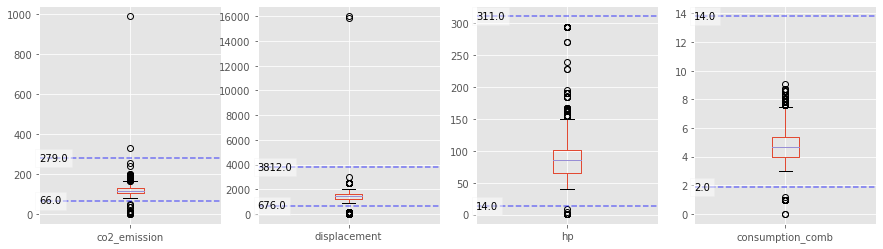

In [14]:
# Create subplots
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

# Plot subplots
i = 0
for column in column_list:
    # Plot boxplot[i]
    df[column].plot.box(ax = ax[i])
    
    # Create limits for outlier detection
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    y_limit_high = Q3 + IQR * 6
    y_limit_low = Q1 - IQR * 1.5
    
    # Draw horizontal lines for limits
    ax[i].axhline(y=y_limit_high, color='b', linestyle='--', alpha = 0.5)
    ax[i].text(0, y_limit_high, y_limit_high.round(), va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=ax[i].get_yaxis_transform())
    ax[i].axhline(y=y_limit_low, color='b', linestyle='--', alpha = 0.5)
    ax[i].text(0, y_limit_low, y_limit_low.round(), va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=ax[i].get_yaxis_transform())
    
    # Next subplot
    i += 1

In [42]:
def detect_replace_outliers(data, columns, thres_low, thres_high):
    '''
    Detects outliers and replace them with NaN in a conservative way to
    prepare data for initial modeling. Specific threshold or limit for each
    feature can be used for better results. This function needs to be
    revisited for further analyis! 
    '''
    data_new = data[columns].copy()
    Q1 = data_new.quantile(0.25)
    Q3 = data_new.quantile(0.75)
    IQR = Q3 - Q1
    
    limit_low = thres_low * IQR
    limit_high = thres_high * IQR
    
    # Print number of outliers by column
    print(((data_new < Q1 - limit_low) | (data_new > Q3 + limit_high)).sum())
    
#     # Print number of rows affected
#     print("\nNumber of rows affected:", 
#           (((data_new < Q1 - limit_low) | (data_new > Q3 + limit_high)).sum(axis=1) > 0 ).sum()
#          ) 
        
    return data_new[(data_new > Q1 - limit_low) & (data_new < Q3 + limit_high)]

#detect_replace_outliers(df, column_list, 1.5, 6);

co2_emission        21
displacement        53
hp                  22
consumption_comb    40
dtype: int64


In [43]:
df[column_list] = detect_replace_outliers(df, column_list, 1.5, 6)

co2_emission        21
displacement        53
hp                  22
consumption_comb    40
dtype: int64


In [44]:
pd.DataFrame({'min':df[column_list].min(), 'max':df[column_list].max()})

,min,max
co2_emission,80.0,253.0
displacement,890.0,2967.0
hp,40.0,294.0
consumption_comb,3.0,9.1


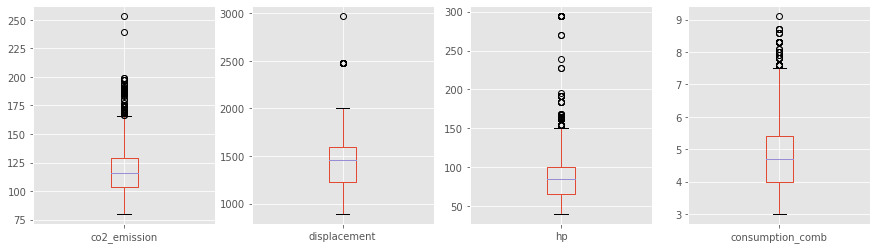

In [45]:
# Create subplots
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

# Plot boxplots
i = 0
for column in column_list:
    df[column].plot.box(ax = ax[i])
    i += 1

## Imputation

In [90]:
# Select non-dummy columns
non_dummy = df.loc[:, ~df.columns.str.contains('ss_|cc_|^ext_|ent_', regex=True)]

# Ratio and number of the missing values for non-dummy columns
pd.DataFrame({"Ratio" : non_dummy.isna().mean().sort_values(ascending=False), 
 "Number": non_dummy.isna().sum().sort_values(ascending=False)})

,Ratio,Number
consumption_comb,0.183617,2923
co2_emission,0.154344,2457
first_registration,0.100320,1597
age,0.100320,1597
km,0.064326,1024
nr_of_seats,0.061373,977
body_color,0.037502,597
displacement,0.034487,549
nr_of_doors,0.013317,212
hp,0.006910,110


In [75]:
# Select dummy columns
dummy = df.loc[:, df.columns.str.contains('ss_|cc_|^ext_|ent_', regex=True)]
# Ratio of the missing values for non-dummy columns
dummy.isna().mean().value_counts()

0.057793    38
0.061687    29
0.186067    17
0.086312    10
dtype: int64

### Imputation Using Make and Model

In [64]:
df.groupby(['make', 'model']).mean()

co2_emission  displacement          hp            km  \
make    model                                                            
Audi    A1          104.306122   1188.746615   76.666539  23925.285173   
        A2                 NaN   1598.000000   85.000000  26166.000000   
        A3          108.892818   1510.703971   90.220355  40340.800000   
Opel    Astra       115.582893   1424.812423   92.914978  39023.504641   
        Corsa       128.372177   1333.395989   60.440724  25616.984630   
        Insignia    135.514572   1672.860288  114.534443  42011.823230   
Renault Clio        111.890801   1252.220427   71.406302  30489.935853   
        Duster      177.000000   1695.030303   77.153846    101.000000   
        Espace      134.316911   1688.773942  130.647120  35152.019108   

                    ss_abs  ss_adaptive_cruise_control  \
make    model                                            
Audi    A1        0.891806                    0.022275   
        A2        1.000000                    1.000000   
        A3        0.960870                    0.145151   
Opel    Astra     0.933078                    0.063086   
        Corsa     0.978346                    0.010827   
        Insignia  0.942582                    0.175608   
Renault Clio      0.976771                    0.012776   
        Duster    1.000000                    0.000000   
        Espace    0.956140                    0.220395   

                  ss_adaptive_headlights  ss_alarm_system  \
make    model                                               
Audi    A1                      0.050915         0.114161   
        A2                      0.000000         0.000000   
        A3                      0.107358         0.243478   
Opel    Astra                   0.105712         0.090793   
        Corsa                   0.036417         0.079232   
        Insignia                0.432104         0.095557   
Renault Clio                    0.067944         0.103949   
        Duster                  0.000000         0.000000   
        Espace                  0.133772         0.138158   

                  ss_blind_spot_monitor  ss_central_door_lock  \
make    model                                                   
Audi    A1                     0.004375              0.840891   
        A2                     0.000000              1.000000   
        A3                     0.013712              0.832776   
Opel    Astra                  0.068201              0.909633   
        Corsa                  0.009350              0.906988   
        Insignia               0.256077              0.868818   
Renault Clio                   0.001742              0.850174   
        Duster                 0.000000              0.058824   
        Espace                 0.489035              0.642544   

                  ss_central_door_lock_with_remote_control  \
make    model                                                
Audi    A1                                        0.162291   
        A2                                        0.000000   
        A3                                        0.199666   
Opel    Astra                                     0.136829   
        Corsa                                     0.183563   
        Insignia                                  0.138726   
Renault Clio                                      0.141696   
        Duster                                    0.000000   
        Espace                                    0.134868   

                  ss_daytime_running_lights  ss_driver_drowsiness_detection  \
make    model                                                                 
Audi    A1                         0.769690                        0.027844   
        A2                         1.000000                        0.000000   
        A3                         0.509030                        0.093980   
Opel    Astra                      0.801790                        0.016198   
        Corsa      

#### Type

In [67]:
df.type.value_counts(dropna=False)

Used              11096
New                1650
Pre-registered     1364
Employee's car     1011
Demonstration       796
NaN                   2
Name: type, dtype: int64

## Golden Dataset

In [86]:
# Prepare data for modeling

# drop_list = []

# # Drop unnecessary columns
# df_new.drop(drop_list, axis=1, inplace=True)

# # Drop rows with NaNs
# df_new.dropna(inplace=True)

# Save the golden dataset to pickle for modeling
df_new.to_pickle('autos_golden_20190716.pkl')